# V2.0 星冕仪可见光相机仿真

In [67]:
%reload_ext autoreload
%autoreload 2

from CpicImgSim.camera import CpicVisEmccd
import numpy as np

from astropy.io import fits
import matplotlib.pyplot as plt

emccd = CpicVisEmccd()

## 测试读出功能

Text(0, 206, 'bias images have a $\\sigma$ = 3 DN variance\ncontroled by `emccd.bias_level_std`')

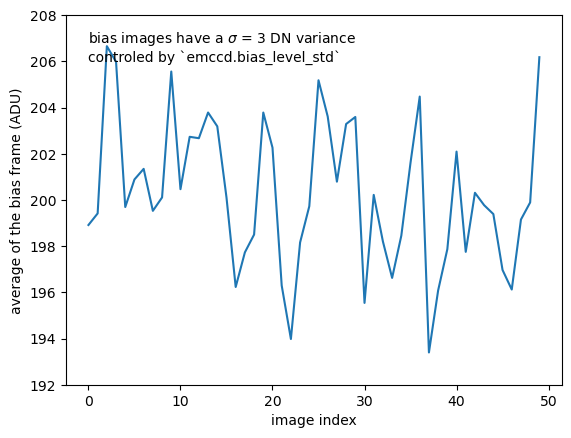

In [68]:


blank = np.zeros(emccd.flat_shape)

bias = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias.fits', bias, overwrite=True)

emccd.switch['bias_vp'] = False
bias_no_vp = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias_novp.fits', bias_no_vp, overwrite=True)

emccd.switch['bias_hp'] = False
bias_no_vphp = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias_novphp.fits', bias_no_vphp, overwrite=True)

emccd.switch['bias_ci'] = False
bias_no_vphpci = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias_novphpci.fits', bias_no_vphpci, overwrite=True)

bias_level = []
for i in range(50):
    imgout = emccd.readout(blank, 1023, 0)
    bias_level.append(imgout.mean())

plt.plot(bias_level)
plt.ylim([192, 208])
plt.xlabel('image index')
plt.ylabel('average of the bias frame (ADU)')
plt.text(0, 206, f"bias images have a $\sigma$ = {emccd.bias_level_std} DN variance\ncontroled by `emccd.bias_level_std`")

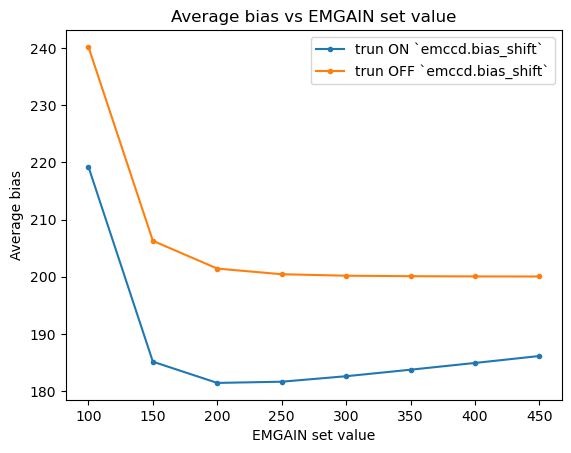

In [83]:
emccd = CpicVisEmccd()
emset_values = list(range(100, 500, 50))
emccd.time_syn(0, initial=True)
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.bias_level_std = 0
emccd.cic = 0.2

emccd.switch['bias_shift'] = True
bias_average = []
for emset in emset_values:
    bias = emccd.readout(blank, emset, 0)
    avg_bias = np.mean(bias)
    bias_average.append(avg_bias)

plt.plot(emset_values, bias_average, '.-', label='trun ON `emccd.bias_shift`')

emccd.switch['bias_shift'] = False
bias_average = []
for emset in emset_values:
    biases = []
    bias = emccd.readout(blank, emset, 0)
    avg_bias = np.mean(bias)
    bias_average.append(avg_bias)

plt.plot(emset_values, bias_average, '.-', label='trun OFF `emccd.bias_shift`')

plt.xlabel('EMGAIN set value')
plt.ylabel('Average bias')
plt.title('Average bias vs EMGAIN set value')
plt.legend()

## 测试倍增功能

Text(0, 0.5, 'Flat image ADU')

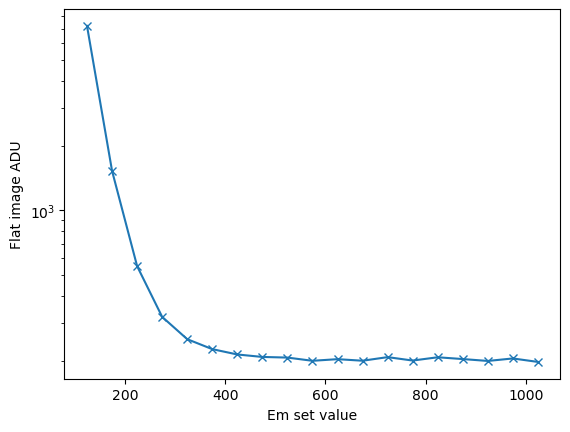

In [48]:
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False

flat_input = np.ones(emccd.flat_shape) * 100
emset_values = list(range(1024, 100, -50))
flat_values = []
for emset in emset_values:
    output = emccd.readout(flat_input, emset, 1)
    flat_values.append(output.mean())

plt.semilogy(emset_values, flat_values, '-x')
plt.xlabel('Em set value')
plt.ylabel('Flat image ADU')

## CIC

199.4295804987726


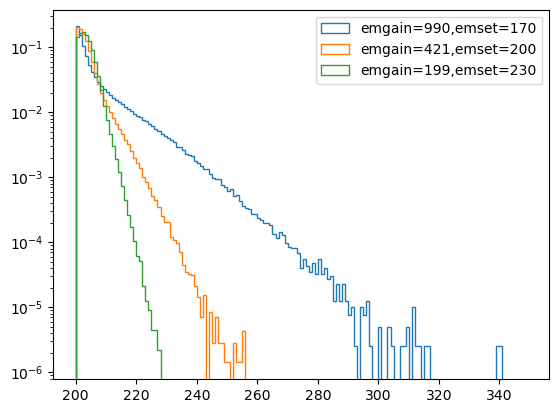

In [18]:

emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.switch['bias_shift'] = False

blank = np.zeros(emccd.flat_shape)

emset = 170
img = emccd.readout(blank, emset, 0)
out = plt.hist(img.flatten(), 
    bins = np.arange(200, 350),
    log=True,
    histtype='step',
    density=True,
    label=f'emgain={emccd.emgain:.0f},emset={emset}')

emset = 200
img = emccd.readout(blank, emset, 0)
out = plt.hist(img.flatten(), 
    bins = np.arange(200, 350),
    log=True,
    histtype='step',
    density=True,
    label=f'emgain={emccd.emgain:.0f},emset={emset}')

emset = 230
img = emccd.readout(blank, emset, 0)
out = plt.hist(img.flatten(), 
    bins = np.arange(200, 350),
    log=True,
    histtype='step',
    density=True,
    label=f'emgain={emccd.emgain:.0f},emset={emset}')
print(emccd.emgain)

plt.legend()

## NOISE factor

In [370]:
emccd = CpicVisEmccd()
emccd.time_syn(0, initial=True)
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.switch['bias_shift'] = False 
emccd.switch['badcolumn'] = False
emccd.switch['nonlinear'] = False
emccd.switch['flat'] = False
emccd.bias_level_std = 0
emccd.cic = 0.0
emccd.em_cte = 1
emccd.readout_noise = 0
emccd.max_adu = 1e100
emccd.emreg_cal_num = 100

flat_photon = 100
flat = np.zeros(emccd.flat_shape) + flat_photon
emgains = []
all_img = []

for emset in range(1024, 100, -100):
    # print(emset)
    img = emccd.readout(flat, emset, 1)
    emgains.append(emccd.emgain)
    all_img.append(img)
    # emgains.append(emccd.emgain_fun(emset, -80))
 
    # print(emset, emccd.emgain)
all_img = np.array(all_img)
fits.writeto('allimg.fits', np.array(all_img), overwrite=True)

10.000066260870149 100.00011150518404


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

In [371]:

all_img = fits.getdata('allimg.fits', lazy_load=False)

In [372]:
emgains = np.array(emgains)

all_img_ph = (all_img[:, 100:-100, 100:-100] - emccd.bias_level) * emccd.ph_per_adu * 1.0
for i, em in enumerate(emgains):
    all_img_ph[i, :, :] = all_img_ph[i, :, :] / em
noise = all_img_ph.std(axis=(1, 2))
mean = all_img_ph.mean(axis=(1, 2))

In [364]:
noise, mean

(array([33.60574038, 34.21298461, 34.93249602, 35.3217174 , 35.19854437,
        34.28232075, 33.04651874, 32.07992281, 31.68921613, 31.62831879]),
 array([ 999.92559802, 1000.05289806, 1000.03528245,  999.98571607,
        1000.01594887,  999.96571835, 1000.01703224, 1000.00263845,
        1000.04036409, 1000.01030035]))

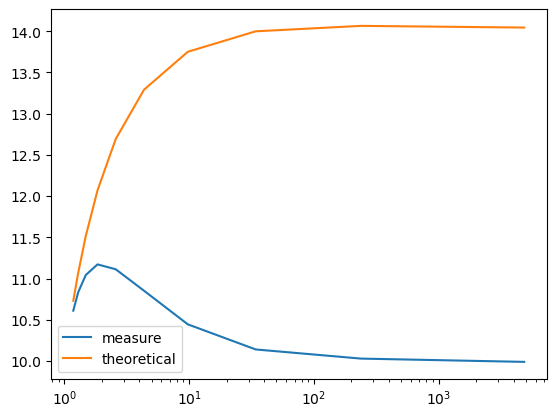

In [369]:
plt.plot(emgains, noise, label='measure')
F2 = 1 / emgains + 2 * (emgains - 1) * emgains ** (-(604 + 1) / 604)
plt.semilogx(emgains, np.sqrt(mean * F2), label='theoretical')
plt.legend()

In [357]:
test = np.zeros(100000) + 10000

Ci = 0
N = 604


100000.0 100000.0 100000.0 100000.0
928092.2498427965 60400000.0 60400000.0 928092.2498427966
4299645.697049777
13257514.596016003
30607707.474308204
56437303.49475673
86575704.63943209
113645799.00501536
130314258.72184795
132601945.40838607
121233060.46245432
100593295.48602746
76382996.34457779
53447728.50342154
34669126.95609617
20953562.1872998
11852429.613183215
6299266.714736975
3156529.1230267915
1495918.8099283434


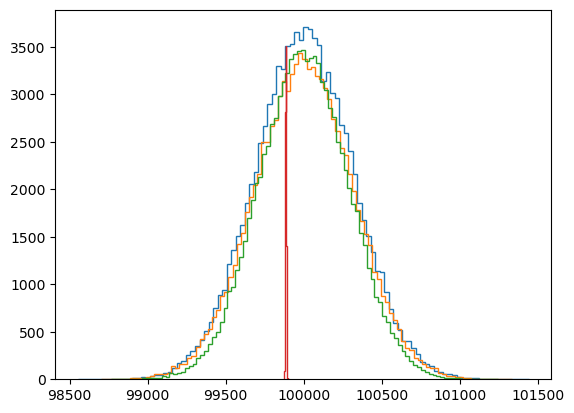

In [337]:
test = np.zeros(100000) + 100000
ps = np.random.poisson(test)
plt.hist(ps, bins=100, histtype='step')

emgain = 10000

gm = np.random.gamma(test, emgain) / emgain
plt.hist(gm, bins=100, histtype='step')

n = 100
pEM = np.exp(np.log(emgain)/n) - 1
dtest = test.astype(int)
for i in range(n):
    dtest += np.random.binomial(dtest, pEM)
dtest = dtest / emgain
x = plt.hist(dtest, bins=100, histtype='step')

N = 604
pEM = np.exp(np.log(emgain)/N) - 1
from math import comb

stest = test.astype(np.int32) * 0
test_int = test.astype(np.int32)

for k in range(20):
    if k < 2:
        xi = comb(N, k) * test_int
        print(xi.mean()*pEM**k, comb(N,k) * test_int.mean(), xi.mean(), comb(N, k) * pEM**k * test_int.mean())
        ci = np.random.binomial(xi, pEM**k)
    else:
        print(comb(N, k) * pEM**k * test_int.mean())
        ci = np.random.poisson(comb(N, k) * pEM**k * test_int)
    stest += ci 
x = plt.hist(stest / emgain, bins=100, histtype='step')



(array([1.000e+00, 7.000e+00, 8.000e+00, 2.200e+01, 3.200e+01, 4.500e+01,
        1.180e+02, 1.480e+02, 2.290e+02, 4.490e+02, 5.640e+02, 7.950e+02,
        1.324e+03, 1.467e+03, 1.878e+03, 2.930e+03, 3.038e+03, 3.648e+03,
        5.239e+03, 4.947e+03, 5.567e+03, 6.963e+03, 6.232e+03, 6.454e+03,
        6.275e+03, 7.300e+03, 5.561e+03, 5.178e+03, 5.405e+03, 3.762e+03,
        3.317e+03, 3.157e+03, 2.082e+03, 1.552e+03, 1.414e+03, 8.850e+02,
        6.320e+02, 5.460e+02, 2.760e+02, 2.020e+02, 1.270e+02, 8.300e+01,
        6.200e+01, 4.100e+01, 1.200e+01, 8.000e+00, 9.000e+00, 3.000e+00,
        2.000e+00, 4.000e+00]),
 array([ 874.  ,  879.32,  884.64,  889.96,  895.28,  900.6 ,  905.92,
         911.24,  916.56,  921.88,  927.2 ,  932.52,  937.84,  943.16,
         948.48,  953.8 ,  959.12,  964.44,  969.76,  975.08,  980.4 ,
         985.72,  991.04,  996.36, 1001.68, 1007.  , 1012.32, 1017.64,
        1022.96, 1028.28, 1033.6 , 1038.92, 1044.24, 1049.56, 1054.88,
        1060.2 , 1065

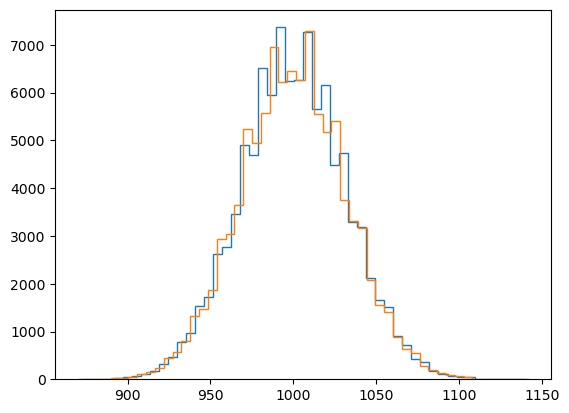

In [342]:

test = np.zeros(100000, dtype=int) + 1000000000
pEM = 0.000001
bi = np.random.binomial(test, pEM)
plt.hist(bi, bins=50, histtype='step')

ps = np.random.poisson(test * pEM)
plt.hist(ps, bins=50, histtype='step')

(array([6.2000e+01, 1.9810e+03, 1.3619e+04, 3.1270e+04, 2.5244e+04,
        2.0126e+04, 6.4080e+03, 1.1510e+03, 1.3500e+02, 4.0000e+00]),
 array([ 4. ,  7.8, 11.6, 15.4, 19.2, 23. , 26.8, 30.6, 34.4, 38.2, 42. ]),
 [<matplotlib.patches.Polygon at 0x1ff1b99e280>])

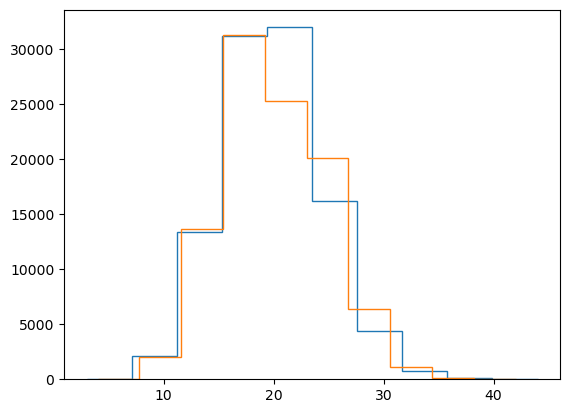

In [346]:
a1 = np.zeros(100000, dtype=int) + 10000
pEM = 0.001
d_a1 = np.random.binomial(a1 + a1, pEM)
plt.hist(d_a1, bins=10, histtype='step')

d_a2 = np.random.binomial(a1, pEM) + np.random.binomial(a1, pEM)
plt.hist(d_a2, bins=10, histtype='step')

(array([3.0000e+00, 6.0000e+00, 2.3000e+01, 1.2900e+02, 4.1300e+02,
        1.7080e+03, 3.5310e+03, 6.6380e+03, 1.3570e+04, 1.4655e+04,
        1.5910e+04, 1.7933e+04, 1.0932e+04, 7.1130e+03, 4.6700e+03,
        1.6460e+03, 7.1200e+02, 3.1900e+02, 6.7000e+01, 2.2000e+01]),
 array([ 54.  ,  58.35,  62.7 ,  67.05,  71.4 ,  75.75,  80.1 ,  84.45,
         88.8 ,  93.15,  97.5 , 101.85, 106.2 , 110.55, 114.9 , 119.25,
        123.6 , 127.95, 132.3 , 136.65, 141.  ]),
 [<matplotlib.patches.Polygon at 0x1ff1b74d8e0>])

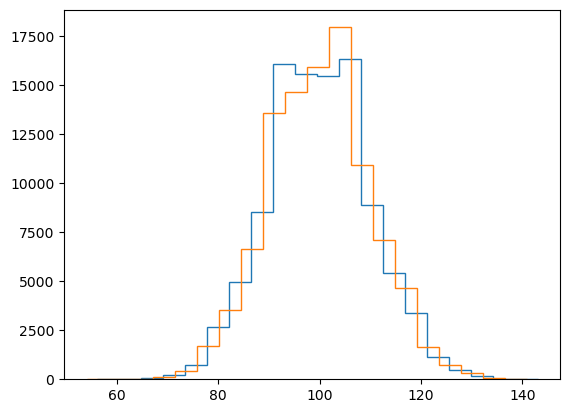

In [351]:
a1 = np.zeros(100000, dtype=int) + 1000000
pEM = 0.01
d_a1 = np.random.binomial(a1, pEM**2)
plt.hist(d_a1, bins=20, histtype='step')

d_a2 = np.random.binomial(np.random.binomial(a1, pEM), pEM)
plt.hist(d_a2, bins=20, histtype='step')

39999.98017907021


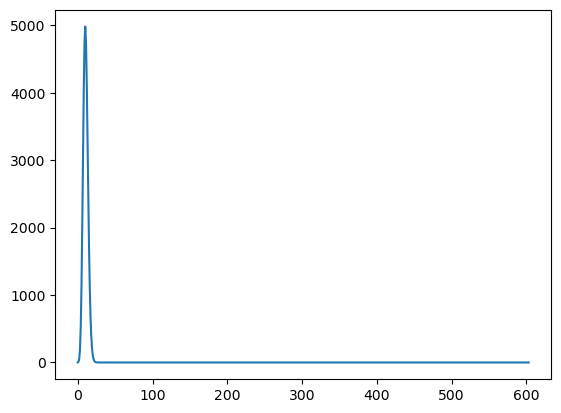

In [241]:
N = 604
emgain = 40000
p = np.exp(np.log(emgain)/N) - 1

import math
bi_curve = []
for i in range(N):
    bi_curve.append(math.comb(N,i)*p**i)

plt.plot(bi_curve)

print(np.sum(bi_curve[:30]))

## 温度变化
连续曝光时温度值的变化

In [79]:
emccd.time_syn(0, initial=True)
times = []
temps = []
imgs = []
emgains = []
for i in range(100):
    img = emccd.readout(blank, 250, 0)
    emgains.append(emccd.emgain)
    imgs.append(img)
    times.append(emccd.system_time)
    temps.append(emccd.ccd_temp)

-80


(0.0, 35.0)

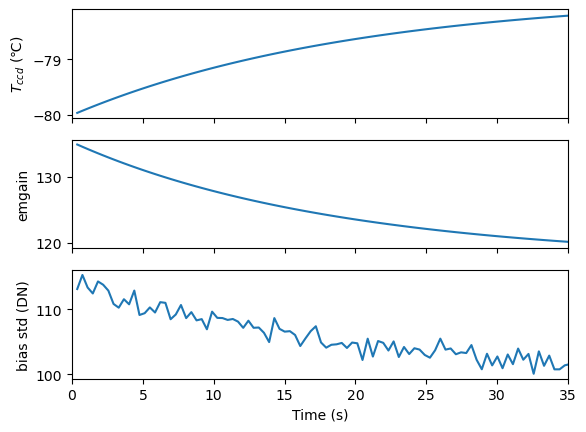

In [97]:
imgs = np.array(imgs)
stds = imgs[:, 100::-100, 100:-100].std(axis=(1, 2))

f, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(times, temps)
ax[0].set_ylabel(r'$T_{ccd}$ (℃)')
ax[1].plot(times, emgains)
ax[1].set_ylabel('emgain')
ax[2].plot(times, stds)

ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('bias std (DN)')
ax[2].set_xlim([0, 35])

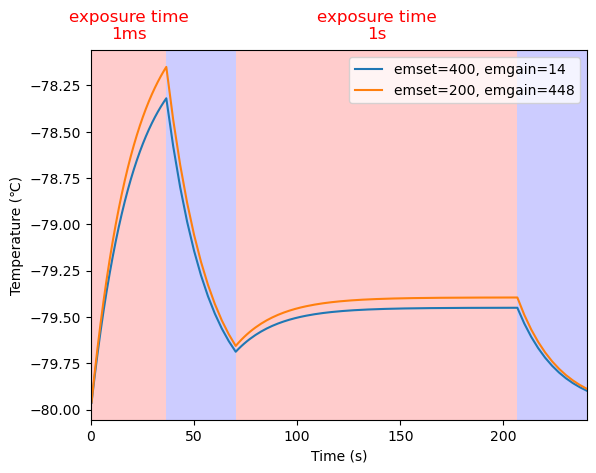

In [130]:



for emset in [400, 200]:

    emccd.time_syn(0, initial=True)
    emccd.emgain_set(emset)

    times = []
    temps = []
    imgs = []
    emgains = []
    def capture_n_frame(n, expt, reading=True):
        for _ in range(n):
            emccd.time_syn(expt + emccd.readout_time, readout=reading)
            temps.append(emccd.ccd_temp)
            times.append(emccd.system_time)
            emgains.append(emccd.emgain)
        return times[-1]

    
    t1 = capture_n_frame(100, 0.001, reading=True)
    t2 = capture_n_frame(10, 3, reading=False)
    t3 = capture_n_frame(100, 1, reading=True)
    t4 = capture_n_frame(10, 3, reading=False)

    plt.plot(times, temps, label=f'emset={emccd.emset}, emgain={np.mean(emgains):.0f}')

plt.xlabel('Time (s)')
plt.ylabel('Temperature (℃)')

t0 = 0
#画四块背景区域，用红蓝背景颜色，区分4个范围,四个区域的分割点分别是t0 - t4
plt.axvspan(t0, t1, color='r', edgecolor=None, alpha=0.2, linewidth=0)
plt.axvspan(t1, t2, color='b', edgecolor=None, alpha=0.2, linewidth=0)
plt.axvspan(t2, t3, color='r', edgecolor=None, alpha=0.2, linewidth=0)
plt.axvspan(t3, t4, color='b', edgecolor=None, alpha=0.2, linewidth=0)
plt.xlim([0, t4])

#两个红色的区域标上曝光时间1ms和曝光时间1s,text的位置使用相对图片的定位方式
plt.text((t0 + t1)/2, -78, 'exposure time\n1ms', fontsize=12, color='r', ha='center')
plt.text((t2 + t3)/2, -78, 'exposure time\n1s', fontsize=12, color='r', ha='center')
plt.legend()


## CTE

In [63]:
emccd = CpicVisEmccd()
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.switch['bias_shift'] = False
emccd.bias_level_std = 0
emccd.readout_noise = 0
emccd.em_cte = 0.9996
emccd.emreg_cal_num = 10
emccd.cic = 0

pinhole = np.zeros(emccd.flat_shape)
pinhole[512, 512] = 10000
cici = emccd.readout(pinhole, 1024, 0)

In [64]:
fits.writeto('cici.fits', cici, overwrite=True)

In [65]:
cici[535:540, 514:520]

array([[200., 200., 200., 200., 200., 200.],
       [200., 200., 200., 200., 200., 200.],
       [200., 200., 200., 200., 200., 200.],
       [200., 200., 200., 200., 200., 200.],
       [200., 200., 200., 200., 200., 200.]])

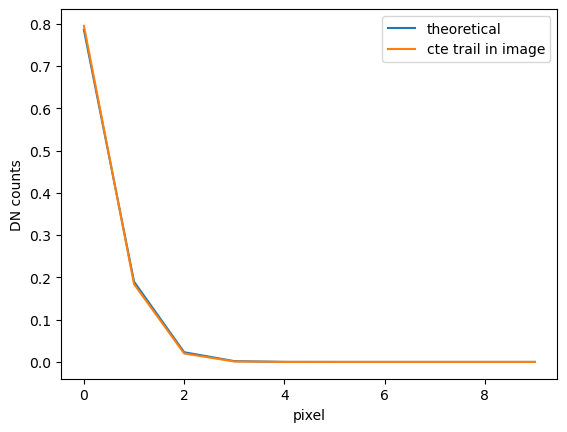

In [66]:
plt.plot(emccd.cti_trail, label='theoretical')
cic_row = cici[514, 536:546].astype(float)  - emccd.bias_level
plt.plot(cic_row/cic_row.sum(), label='cte trail in image')

plt.xlabel('pixel')
plt.ylabel('DN counts')
plt.legend()